In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%qtconsole --colors=linux
plt.style.use('ggplot')

from matplotlib import gridspec
from theano import tensor as tt
from scipy import stats

### Note from Junpeng Lao
In PyMC3, a discrete latent variable could be very easily expressed as a discrete random variable. PyMC3 will assign this discrete variable with a sampler (usually a Metropolis sampler), while the rest of the (continous) RVs sample with NUTS. However, care must be taken, as mixing different sampler is in general not a good idea. The standard treatment is integrate out the latent variables, as done in Stan.

# Chapter 6 - Latent-mixture models
## 6.1 Exam scores


Exam result consistent of 2 group of students - one group is purely guess and the other with a >.5 accuracy rate

$$ z_{i} \sim \text{Bernoulli}(0.5)  $$
$$ \phi \sim \text{Uniform}(0.5, 1) $$
$$ \psi = 0.5 $$  
$$   \theta_{i} \sim
\begin{cases}
\phi  & \text{if $z_{i} = 1$} \\
\psi  & \text{if $z_{i} = 0$}
\end{cases}  $$
$$ k_{i} \sim \text{Binomial}(\theta_{i}, n) $$

(It is also possible to estimate this model using a EM algorthim.)

logp = -162.37, ||grad|| = 0: 100%|██████████| 2/2 [00:00<00:00, 555.87it/s]
Assigned BinaryGibbsMetropolis to zi
100%|██████████| 30500/30500.0 [01:17<00:00, 394.67it/s]


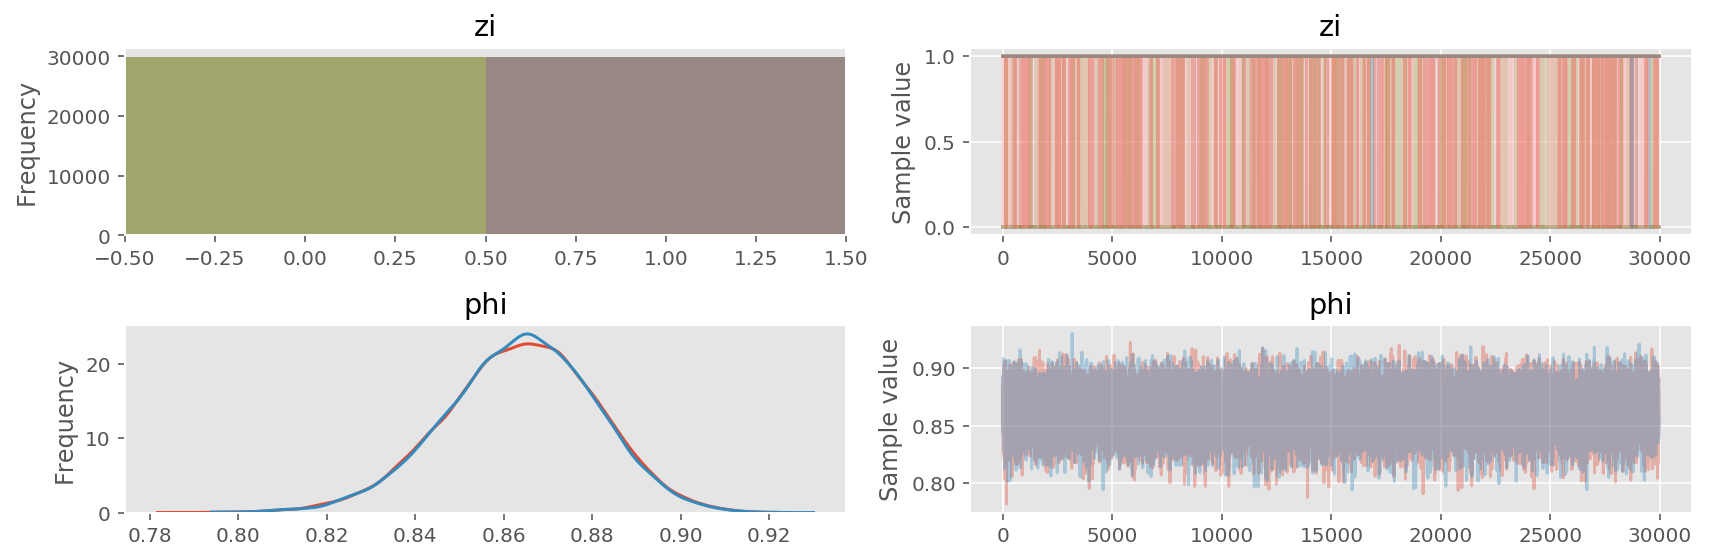

Grouping [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]


In [2]:
# pymc3
k = np.array([21,17,21,18,22,31,31,34,34,35,35,36,39,36,35])
p = len(k) #number of people
n = 40 # number of questions

with pm.Model() as model1:
    # group prior
    zi = pm.Bernoulli('zi', p=.5, shape=p)
    # accuracy prior
    phi = pm.Uniform('phi', upper=1, lower=.5)
    psi = .5
    theta = pm.Deterministic('theta', phi*tt.eq(zi, 1) + psi*tt.eq(zi, 0))
    
    # observed
    ki = pm.Binomial('ki', p=theta, n=n, observed=k)
    
    # step=pm.NUTS()
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    
    trace1=pm.sample(3e4, step, init=None)

pm.traceplot(trace1[50:], ['zi', 'phi']);

ztrace = trace1['zi'][50:]
print('Grouping', ztrace[-1, :])

## 6.2 Exam scores with individual differences


$$ z_{i} \sim \text{Bernoulli}(0.5)  $$
$$ \mu \sim \text{Uniform}(0.5, 1) $$
$$ \lambda \sim \text{Gamma}(.001, .001)$$  
$$ \phi_{i} \sim \text{Gaussian}(\mu, \lambda)_{\mathcal I(0,1)} $$
$$ \psi = 0.5 $$  
$$   \theta_{i} \sim
\begin{cases}
\phi_{i}  & \text{if $z_{i} = 1$} \\
\psi  & \text{if $z_{i} = 0$}
\end{cases}  $$
$$ k_{i} \sim \text{Binomial}(\theta_{i}, n) $$

logp = -136.63, ||grad|| = 10.317: 100%|██████████| 17/17 [00:00<00:00, 2333.22it/s]
Assigned BinaryGibbsMetropolis to zi
100%|█████████▉| 30499/30500.0 [03:42<00:00, 145.63it/s]/Users/jlao/Documents/Github/pymc3/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 0 contains 1249 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 30500/30500.0 [03:42<00:00, 137.24it/s]
/Users/jlao/Documents/Github/pymc3/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 1 contains 1194 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))


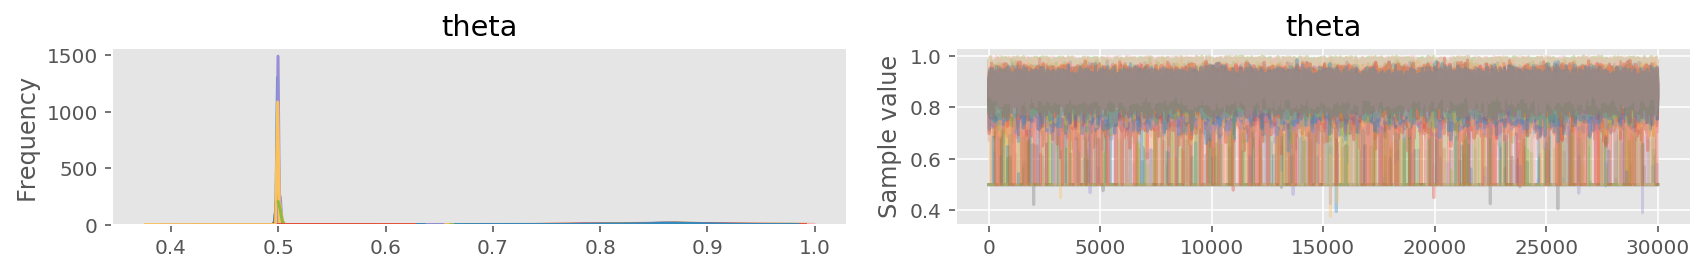

Grouping [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]


In [3]:
# pymc3 - need some tuning to get the same result as in JAGS
k = np.array([21,17,21,18,22,31,31,34,34,35,35,36,39,36,35])
p = len(k) #number of people
n = 40 # number of questions

with pm.Model() as model2:
    # group prior
    zi = pm.Bernoulli('zi', p=.5, shape=p)
    # accuracy prior
    psi = .5
    mu = pm.Uniform('mu', upper=1, lower=.5)
    lambda_ = pm.Gamma('lambda_', alpha=.001, beta=.001)
    phi = pm.Normal('phi', mu=mu, tau=lambda_, shape=p)
    
    theta = pm.Deterministic('theta', phi*tt.eq(zi, 1) + psi*tt.eq(zi, 0))
    
    # observed
    ki = pm.Binomial('ki', p=theta, n=n, observed=k)
    
    # step=pm.NUTS()
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    
    trace2=pm.sample(3e4, step=step, njobs=2)

pm.traceplot(trace2[:], ['theta']);

ztrace = trace2['zi'][:]
print('Grouping', ztrace[-1, :])

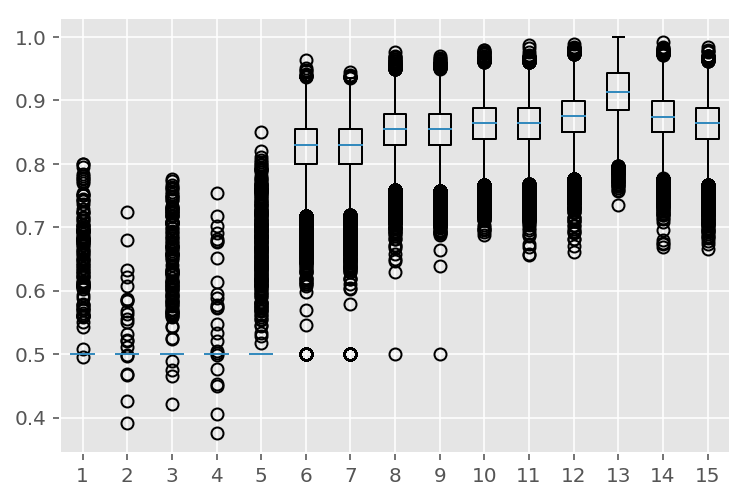

In [4]:
plt.figure()
thetapost = trace2['theta'][25000:]
plt.boxplot(thetapost)

## 6.3 Twenty questions


Suppose a group of 10 people attend a lecture, and are asked a set of 20 questions afterwards, with every answer being either correct or incorrect.  
$$ p_{i},q_{j} \sim \text{Beta}(1,1)$$
$$ \theta_{ij} = p_{i}q_{j} $$
$$ k_{ij} \sim \text{Bernoulli}(\theta_{ij}) $$ 

Assigned NUTS to pi_logodds__
Assigned NUTS to qi_logodds__
Assigned BinaryGibbsMetropolis to kij_missing
100%|██████████| 20000/20000.0 [00:55<00:00, 358.76it/s]


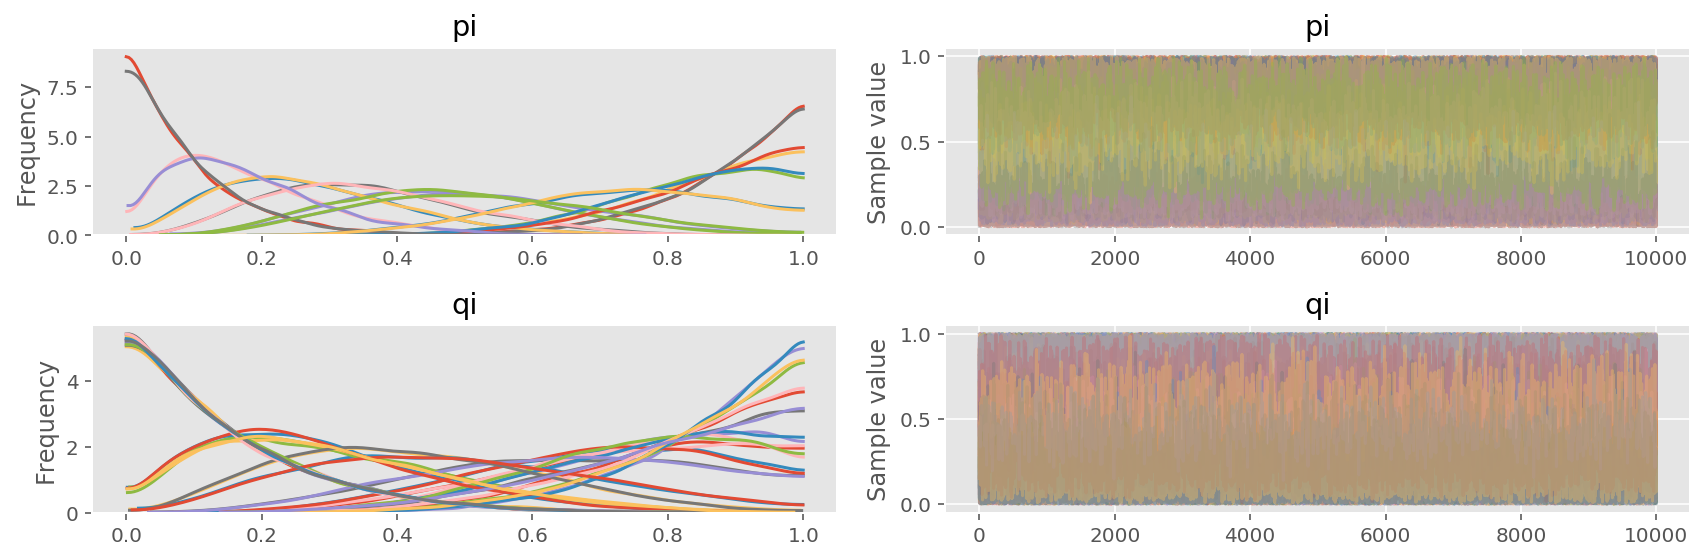

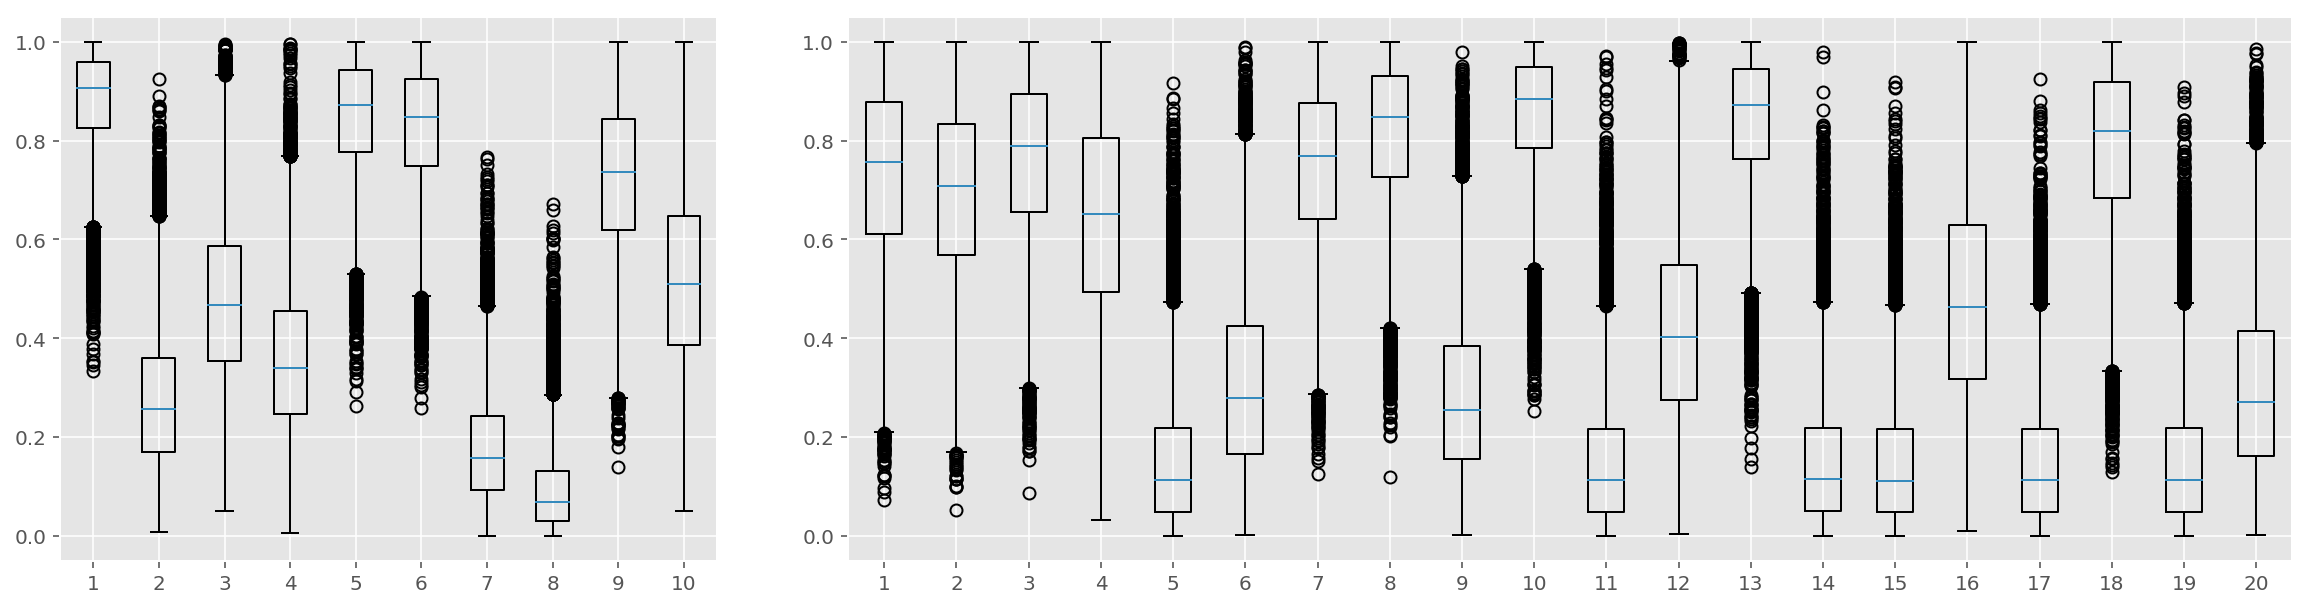

In [5]:
dset = 2
if dset==1:
    k = np.array([1,1,1,1,0,0,1,1,0,1,0,0,1,0,0,1,0,1,0,0,
        0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
        0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,
        0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,
        1,0,1,1,0,1,1,1,0,1,0,0,1,0,0,0,0,1,0,0,
        1,1,0,1,0,0,0,1,0,1,0,1,1,0,0,1,0,1,0,0,
        0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,
        0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
        0,1,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,1,
        1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0]).reshape(10,-1)
elif dset==2:
    k = np.ma.masked_values([1,1,1,1,0,0,1,1,0,1,0,0,-999,0,0,1,0,1,0,0,
        0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
        0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,
        0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,
        1,0,1,1,0,1,1,1,0,1,0,0,1,0,0,0,0,1,0,0,
        1,1,0,1,0,0,0,1,0,1,0,1,1,0,0,1,0,1,0,0,
        0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,
        0,0,0,0,-999,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
        0,1,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,1,
        1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,-999,0,0], value=-999).reshape(10,-1)
# print(k)
Np, Nq = k.shape

with pm.Model() as model3:
    # prior
    pi = pm.Beta('pi', alpha=1, beta=1, shape=Np)
    qi = pm.Beta('qi', alpha=1, beta=1, shape=Nq)
    # accuracy prior
    theta = pm.Deterministic('theta', tt.outer(pi, qi))
    # observed
    kij = pm.Bernoulli('kij', p=theta, observed=k)
    
    trace3=pm.sample(1e4, tune=10000)

pm.traceplot(trace3[:], ['pi', 'qi']);

fig = plt.figure(figsize=(20, 5)) 
gs = gridspec.GridSpec(1, 3) 
ax0 = plt.subplot(gs[0])
pipost = trace3['pi'][5000:]
ax0.boxplot(pipost)

ax1 = plt.subplot(gs[1:])
qipost = trace3['qi'][5000:]
ax1.boxplot(qipost)

## 6.4 The two-country quiz


$$ \alpha \sim \text{Uniform}(0,1) $$
$$ \beta \sim \text{Uniform}(0,\alpha) $$
$$ x_{i} \sim \text{Bernoulli}(0.5) $$
$$ z_{j} \sim \text{Bernoulli}(0.5) $$
$$   \theta_{ij} \sim
\begin{cases}
\alpha  & \text{if $x_{i} = z_{j}$} \\
\beta  & \text{if $x_{i} \neq z_{j}$}
\end{cases}  $$
$$ k_{ij} \sim \text{Bernoulli}(\theta_{ij}) $$ 

Assigned NUTS to alpha_interval__
Assigned NUTS to beta_interval__
Assigned BinaryGibbsMetropolis to xi
Assigned BinaryGibbsMetropolis to zj
Assigned BinaryGibbsMetropolis to kij_missing
100%|██████████| 3500/3500.0 [00:56<00:00, 64.36it/s]


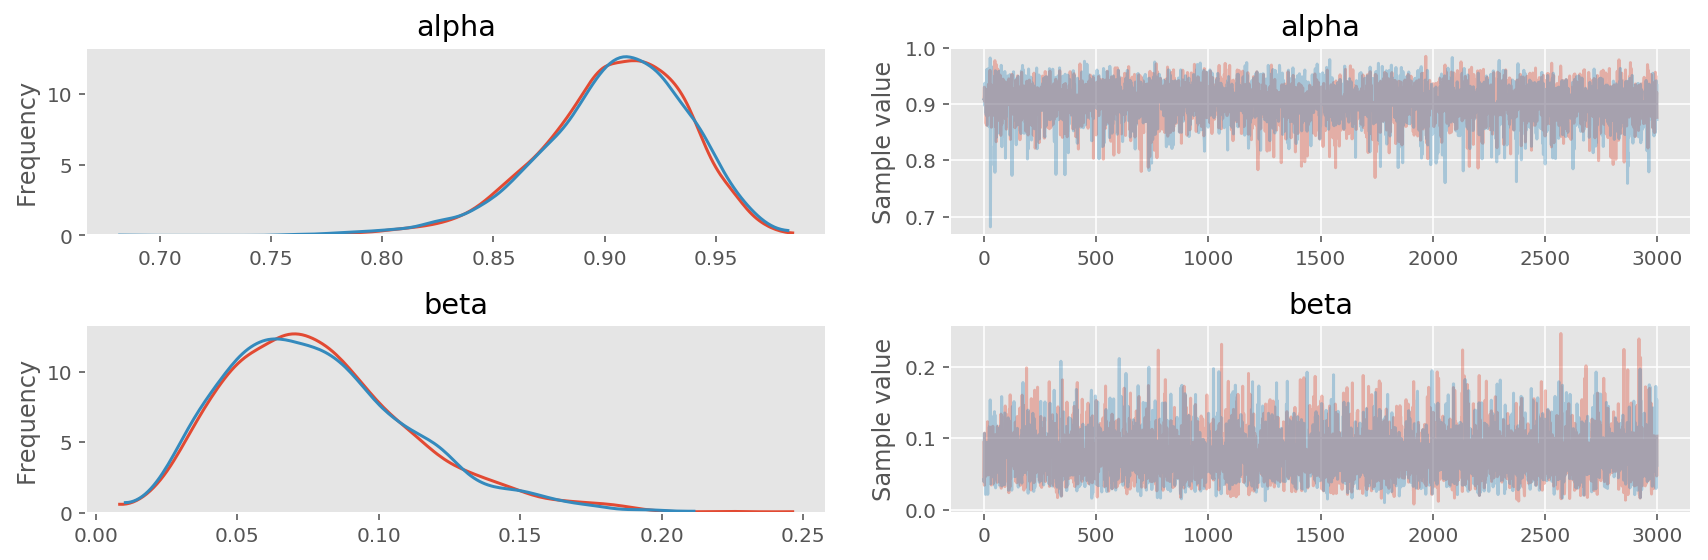

xi [0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 1]
zj [0 1 1 0 0 1 1 0]


In [6]:
dset = 3
if dset==1:
    k = np.array([1,0,0,1,1,0,0,1,
      1,0,0,1,1,0,0,1,
      0,1,1,0,0,1,0,0,
      0,1,1,0,0,1,1,0,
      1,0,0,1,1,0,0,1,
      0,0,0,1,1,0,0,1,
      0,1,0,0,0,1,1,0,
      0,1,1,1,0,1,1,0]).reshape(8,-1)
elif dset==2:
    k = np.ma.masked_values([1,0,0,1,1,0,0,1,
      1,0,0,1,1,0,0,1,
      0,1,1,0,0,1,0,0,
      0,1,1,0,0,1,1,0,
      1,0,0,1,1,0,0,1,
      0,0,0,1,1,0,0,1,
      0,1,0,0,0,1,1,0,
      0,1,1,1,0,1,1,0,
      1,0,0,1,-999,-999,-999,-999,
      0,-999,-999,-999,-999,-999,-999,-999,
      -999,-999,-999,-999,-999,-999,-999,-999], value=-999).reshape(11,-1)
elif dset==3:
    k = np.ma.masked_values([1,0,0,1,1,0,0,1,
      1,0,0,1,1,0,0,1,
      1,0,0,1,1,0,0,1,
      1,0,0,1,1,0,0,1,
      1,0,0,1,1,0,0,1,
      1,0,0,1,1,0,0,1,
      1,0,0,1,1,0,0,1,
      1,0,0,1,1,0,0,1,
      1,0,0,1,1,0,0,1,
      1,0,0,1,1,0,0,1,
      1,0,0,1,1,0,0,1,
      1,0,0,1,1,0,0,1,
      0,1,1,0,0,1,0,0,
      0,1,1,0,0,1,1,0,
      1,0,0,1,1,0,0,1,
      0,0,0,1,1,0,0,1,
      0,1,0,0,0,1,1,0,
      0,1,1,1,0,1,1,0,
      1,0,0,1,-999,-999,-999,-999,
      0,-999,-999,-999,-999,-999,-999,-999,
      -999,-999,-999,-999,-999,-999,-999,-999], value=-999).reshape(21,-1)

Nx, Nz = k.shape

with pm.Model() as model4:
    # prior
    alpha = pm.Uniform('alpha', lower=0, upper=1)
    beta = pm.Uniform('beta', lower=0, upper=alpha)
    
    xi = pm.Bernoulli('xi', p=.5, shape=Nx)
    zj = pm.Bernoulli('zj', p=.5, shape=Nz)
    
    # accuracy prior
    theta = pm.Deterministic('theta',
                             alpha*(tt.outer(tt.eq(xi, 0), tt.eq(zj, 0)) + 
                                    tt.outer(tt.eq(xi, 1), tt.eq(zj, 1))) +
                             beta*(tt.outer(tt.eq(xi, 0), tt.eq(zj, 1)) +
                                   tt.outer(tt.eq(xi, 0), tt.eq(zj, 1))))
    
    # observed
    kij = pm.Bernoulli('kij', p=theta, observed=k)
    
    trace4=pm.sample(3e3)

pm.traceplot(trace4[:], ['alpha', 'beta']);

xtrace = trace4['xi'][:]
print('xi', xtrace[-1,:])
ztrace = trace4['zj'][:]
print('zj', ztrace[-1,:])

## 6.5 Assessment of malingering


$$ \psi^b \sim \text{Uniform}(0.5,1) $$
$$ \psi^m \sim \text{Uniform}(0,\psi^b) $$
$$ z_{i} \sim \text{Bernoulli}(0.5) $$
$$   \theta_{ij} \sim
\begin{cases}
\psi^b  & \text{if $z_{i} = 0$} \\
\psi^m  & \text{if $z_{i} = 1$}
\end{cases}  $$
$$ k_{i} \sim \text{Binomial}(\theta_{i},n) $$ 

Assigned NUTS to psib_interval__
Assigned NUTS to psim_interval__
Assigned BinaryGibbsMetropolis to zi
100%|██████████| 3500/3500.0 [00:14<00:00, 236.45it/s]
/Users/jlao/Documents/Github/pymc3/pymc3/step_methods/hmc/nuts.py:452: UserWarning: The acceptance probability in chain 1 does not match the target. It is 0.880406026259, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))


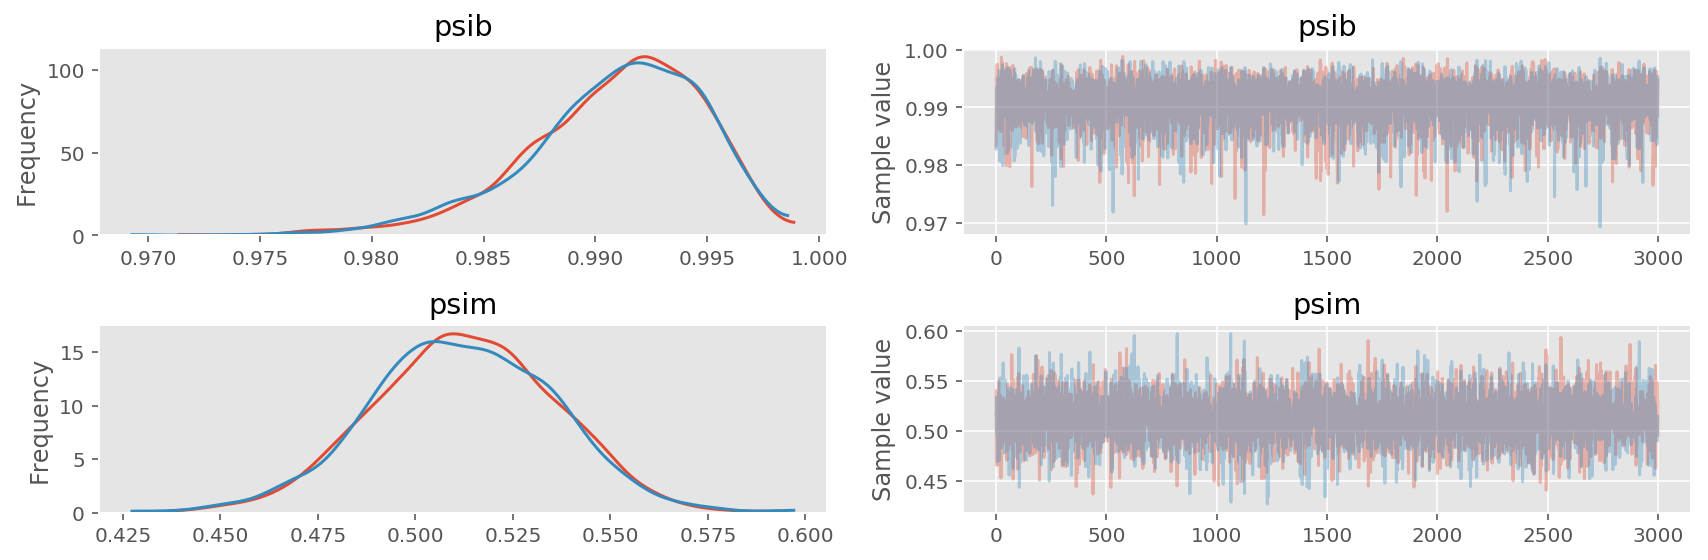

zi-end [0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 1 1 1]
zi-mode ModeResult(mode=array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1]]), count=array([[6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000,
        6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]]))


In [7]:
k = np.array([45,45,44,45,44,45,45,45,45,45,30,20,6,44,44,27,25,17,14,27,35,30])
p = len(k) # number of people
n = 45        # number of questions

with pm.Model() as model5:
    # prior
    psib = pm.Uniform('psib', lower=0.5, upper=1)
    psim = pm.Uniform('psim', lower=0, upper=psib)
    
    zi = pm.Bernoulli('zi', p=.5, shape=p)
    
    theta = pm.Deterministic('theta', psib*(tt.eq(zi, 0)) + psim*(tt.eq(zi, 1)))
    
    # observed
    kij = pm.Binomial('kij', p=theta, n=n, observed=k)
    
    trace5=pm.sample(3e3)

pm.traceplot(trace5[:], ['psib', 'psim']);

ztrace = trace5['zi'][:]
print('zi-end', ztrace[-1,:])
print('zi-mode', stats.mode(ztrace[:],axis=0))

## 6.6 Individual differences in malingering


$$ \mu_{b} \sim \text{Beta}(1,1) $$
$$ \mu_{d} \sim \text{Gaussian}(0,0.5)_{\mathcal I(0,∞)} $$
$$ \lambda_{b} \sim \text{Uniform}(40,800) $$
$$ \lambda_{m} \sim \text{Uniform}(4,100) $$
$$ z_{i} \sim \text{Bernoulli}(\phi) $$
$$   \theta_{i} \sim
\begin{cases}
\text{Beta}(\mu_{b}\lambda_{b},(1-\mu_{b})\lambda_{b})  & \text{if $z_{i} = 0$} \\
\text{Beta}(\mu_{m}\lambda_{m},(1-\mu_{m})\lambda_{m})  & \text{if $z_{i} = 1$}
\end{cases}  $$
$$ k_{i} \sim \text{Binomial}(\theta_{i},n) $$ 
$$ \text{logit}\mu_{m} = \text{logit}\mu_{b} - \mu_{d} $$
$$ \phi \sim \text{Beta}(5,5)$$

In [8]:
k = np.array([45,45,44,45,44,45,45,45,45,45,30,20,6,44,44,27,25,17,14,27,35,30])
p = len(k) # number of people
n = 45        # number of questions

with pm.Model() as model6:
    # prior
    mub = pm.Beta('mub', alpha=1, beta=1)
    mud = pm.HalfNormal('mud', sd=.5)
    lambdab = pm.Uniform('lambdab', lower=40, upper=800)
    lambdam = pm.Uniform('lambdam', lower=4, upper=100)
    psi = pm.Beta('psi', alpha=5, beta=5)
    
    zi = pm.Bernoulli('zi', p=psi, shape=p)
    
    mum = pm.Deterministic('mum', 1/(1+tt.exp(tt.log(1/mub-1)+mud)))
    theta1 = pm.Beta('theta1', alpha=mub*lambdab, beta=(1-mub)*lambdab)
    theta2 = pm.Beta('theta2', alpha=mum*lambdam, beta=(1-mum)*lambdam)
    
    theta = pm.Deterministic('theta', theta1*(tt.eq(zi, 0)) + theta2*(tt.eq(zi, 1)))
    
    # observed
    kij = pm.Binomial('kij', p=theta, n=n, observed=k)
    trace6 = pm.sample(1e4)

Assigned NUTS to mub_logodds__
Assigned NUTS to mud_log__
Assigned NUTS to lambdab_interval__
Assigned NUTS to lambdam_interval__
Assigned NUTS to psi_logodds__
Assigned BinaryGibbsMetropolis to zi
Assigned NUTS to theta1_logodds__
Assigned NUTS to theta2_logodds__
100%|█████████▉| 10494/10500.0 [02:32<00:00, 68.72it/s]/Users/jlao/Documents/Github/pymc3/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 0 contains 2 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 10500/10500.0 [02:32<00:00, 68.85it/s]
/Users/jlao/Documents/Github/pymc3/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 1 contains 2 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))


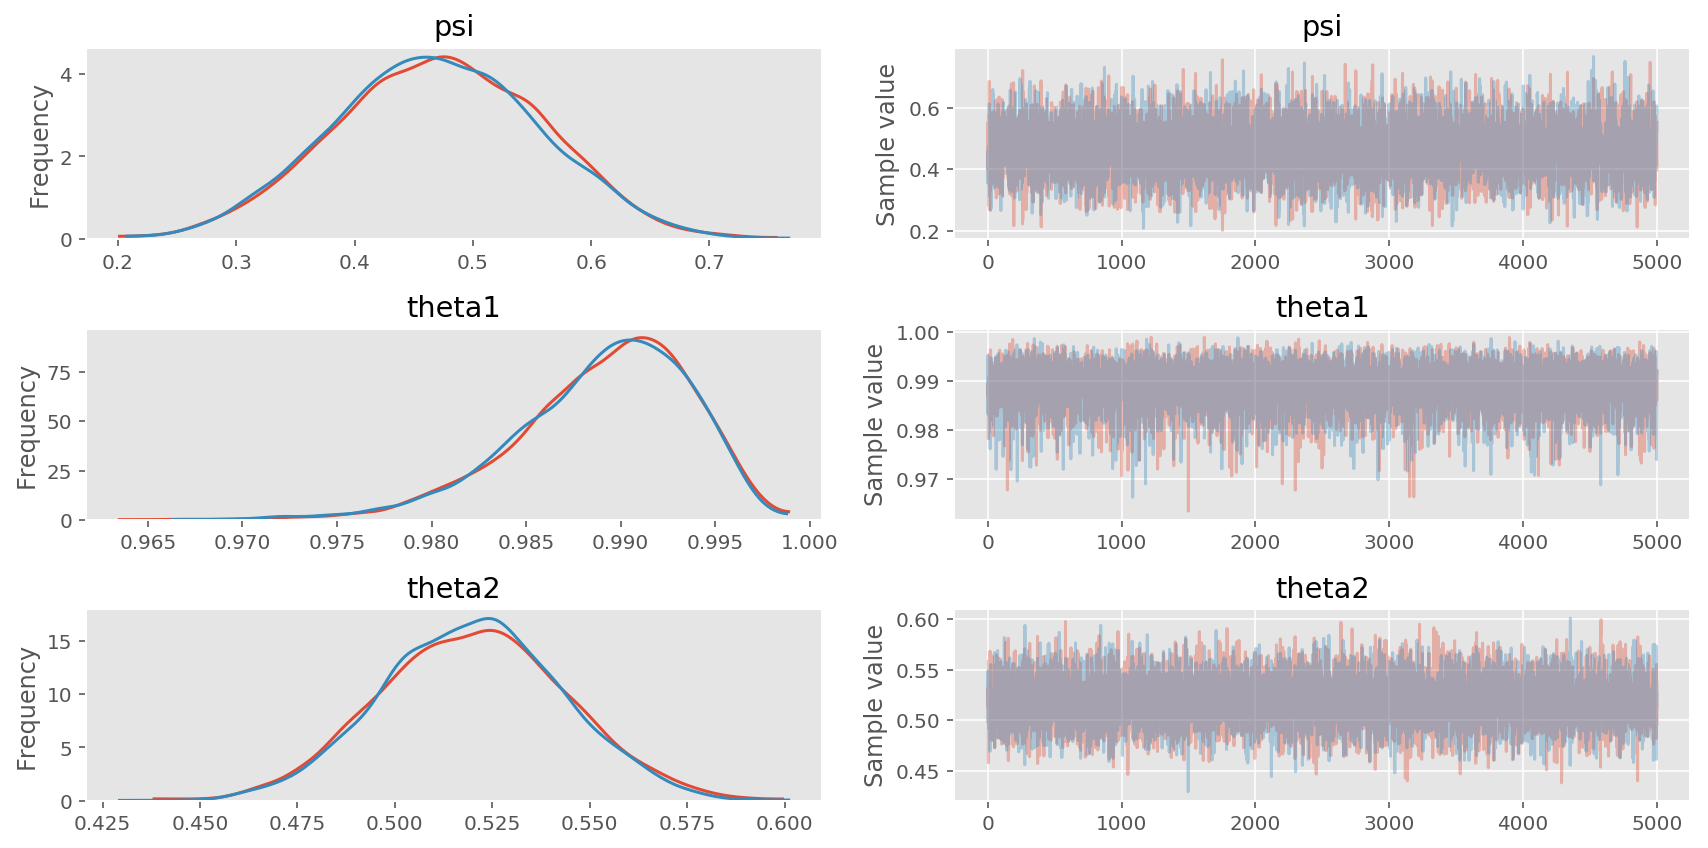

zi [0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 1 1 1]
zi ModeResult(mode=array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1]]), count=array([[15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000,
        15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000,
        15000, 15000, 14998, 15000]]))


In [9]:
burnin = 5000
pm.traceplot(trace6[burnin:], ['psi', 'theta1', 'theta2']);

ztrace = trace6['zi'][burnin:]
print('zi', ztrace[-1, :])
print('zi', stats.mode(ztrace[:], axis=0))

## 6.7 Alzheimer's recall test cheating


$$ \mu_{b} \sim \text{Beta}(1,1) $$
$$ \mu_{d} \sim \text{Gaussian}(0,0.5)_{\mathcal I(0,∞)} $$
$$ \lambda_{b} \sim \text{Uniform}(5,50) $$
$$ \lambda_{c} \sim \text{Uniform}(5,50) $$
$$ z_{i} \sim \text{Bernoulli}(\phi) $$
$$   \theta_{i} \sim
\begin{cases}
\text{Beta}(\mu_{b}\lambda_{b},(1-\mu_{b})\lambda_{b})  & \text{if $z_{i} = 0$} \\
\text{Beta}(\mu_{c}\lambda_{c},(1-\mu_{c})\lambda_{c})  & \text{if $z_{i} = 1$}
\end{cases}  $$
$$ k_{i} \sim \text{Binomial}(\theta_{i},n) $$ 
$$ \text{logit}\mu_{c} = \text{logit}\mu_{b} + \mu_{d} $$
$$ \phi \sim \text{Beta}(5,5)$$

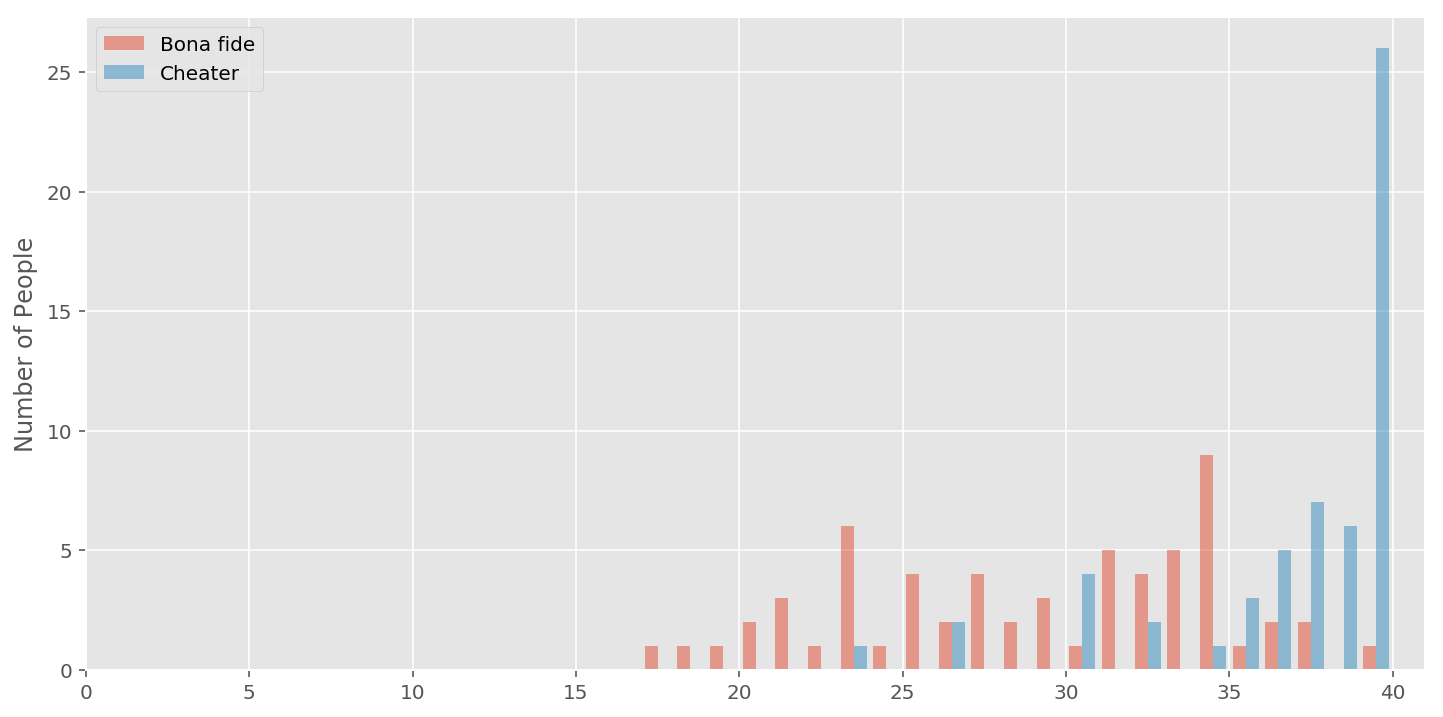

In [10]:
# Load data
dat = pd.read_csv('cheat.csv',header=None)
truth = pd.read_csv('cheatt.csv',header=None)
k = np.array(dat.sum(axis=1))
t1 = truth.values.T

p = len(k) # number of people
n = 40     # number of questions

fig = plt.figure(figsize=(12, 6))
bins = np.arange(0,n+1)
plt.hist([k[t1[0,:]==0],k[t1[0,:]==1]], bins, alpha=0.5, label=['Bona fide','Cheater'])
plt.xlim([0,41])
plt.legend(loc='upper left')
plt.ylabel('Number of People')

In [11]:
with pm.Model() as model7:
    # prior
    mub = pm.Beta('mub', alpha=1, beta=1)
    mud = pm.HalfNormal('mud', sd=.5)
    lambdab = pm.Uniform('lambdab', lower=5, upper=50)
    lambdac = pm.Uniform('lambdac', lower=5, upper=50)
    psi = pm.Beta('psi', alpha=5, beta=5)
    # psi = pm.Uniform("psi",lower=0,upper=1)
    zi = pm.Bernoulli('zi', p=psi, shape=p)
    
    muc = pm.Deterministic('muc', 1/(1+tt.exp(tt.log(1/mub-1)-mud)))
    theta1 = pm.Beta('theta1', alpha=mub*lambdab, beta=(1-mub)*lambdab)
    theta2 = pm.Beta('theta2', alpha=muc*lambdac, beta=(1-muc)*lambdac)
    
    theta = pm.Deterministic('theta', theta1*(tt.eq(zi, 0)) + theta2*(tt.eq(zi, 1)))
    # theta = theta1*(T.eq(zi,0))+theta2*(T.eq(zi,1))
    # observed
    kij = pm.Binomial('kij', p=theta, n=n, observed=k)

logp = -623.72, ||grad|| = 0.017222: 100%|██████████| 59/59 [00:00<00:00, 1512.86it/s]
Assigned NUTS to mub_logodds__
Assigned NUTS to mud_log__
Assigned NUTS to lambdab_interval__
Assigned NUTS to lambdac_interval__
Assigned NUTS to psi_logodds__
Assigned BinaryGibbsMetropolis to zi
Assigned NUTS to theta1_logodds__
Assigned NUTS to theta2_logodds__
100%|█████████▉| 3499/3500.0 [03:39<00:00, 16.93it/s]/Users/jlao/Documents/Github/pymc3/pymc3/step_methods/hmc/nuts.py:452: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.886543502856, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
100%|██████████| 3500/3500.0 [03:39<00:00, 15.95it/s]


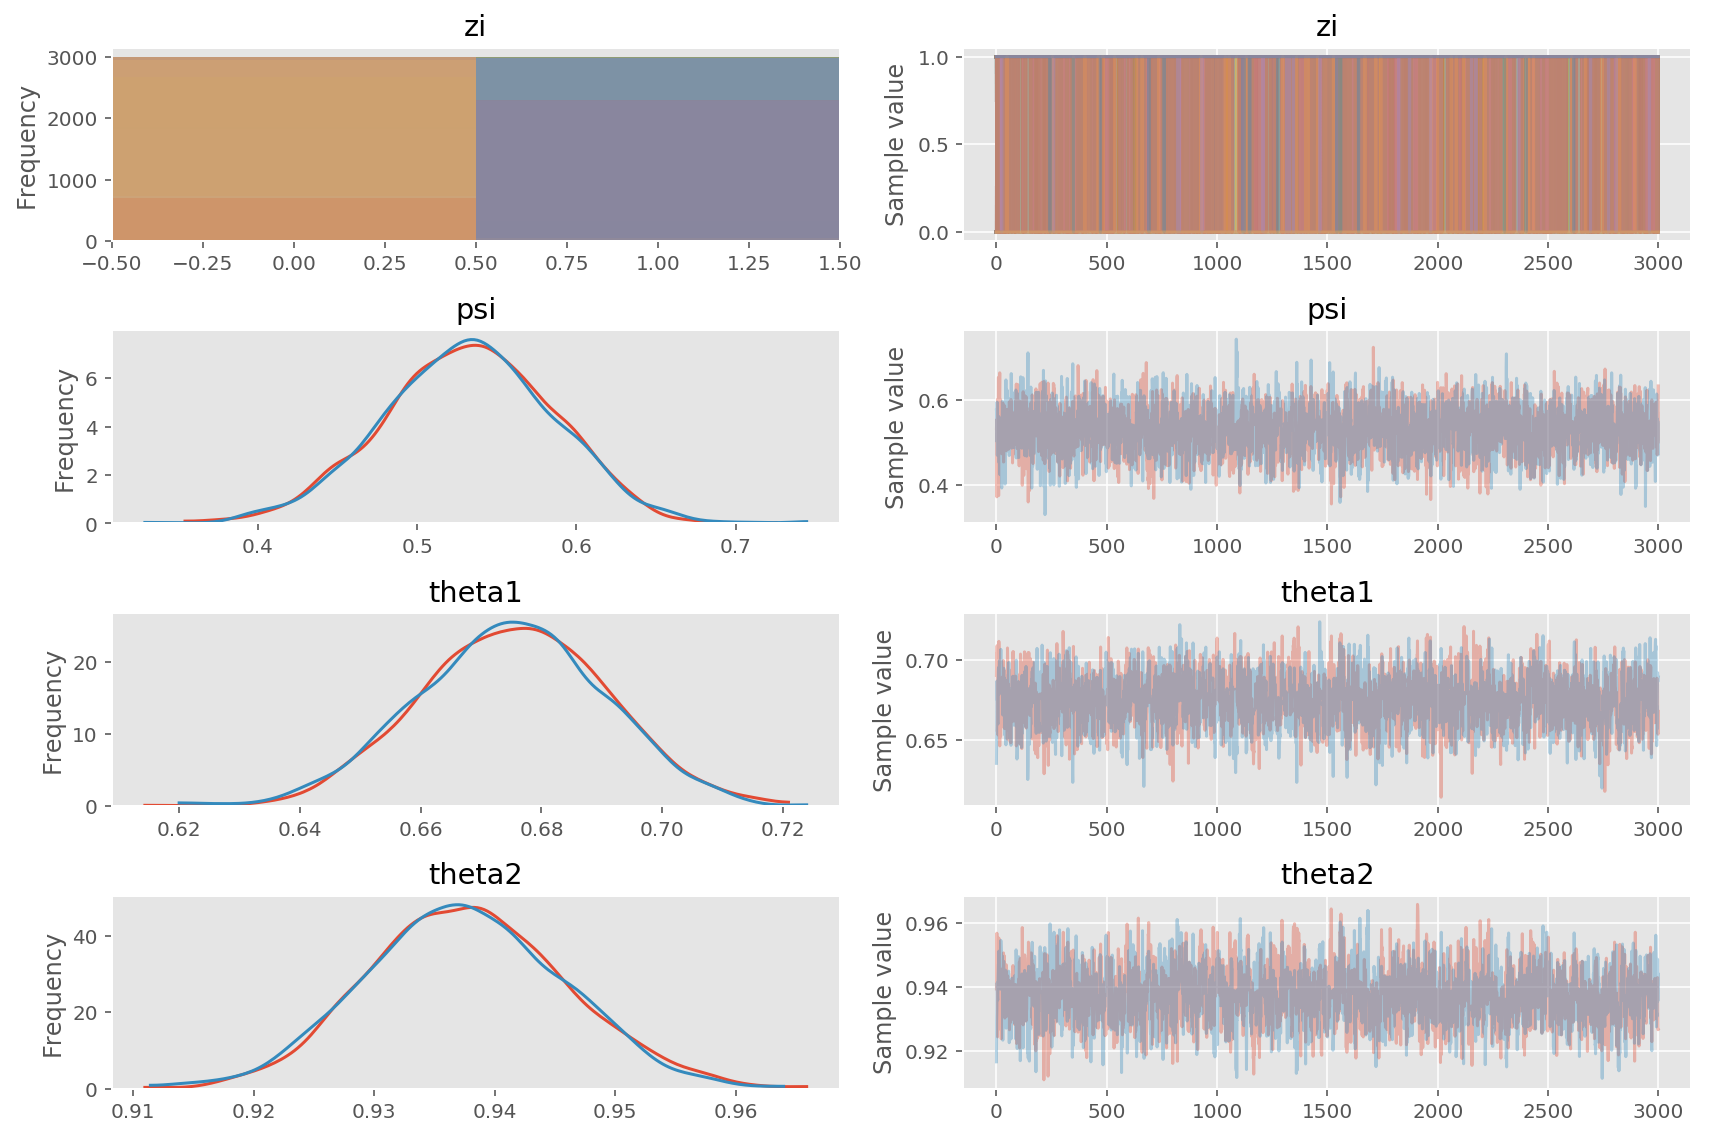

zi [0 0 1 1 0 0 0 0 0 0 1 0 1 1 0 1 1 0 1 1 0 0 1 0 1 1 1 0 1 0 1 0 1 0 0 1 1
 0 0 1 1 1 0 1 0 1 1 1 1 1 0 0 1 0 1 0 0 1 1 0 1 0 0 0 1 1 0 0 1 0 1 0 1 1
 1 0 0 1 1 0 0 1 0 1 0 0 0 1 0 1 0 0 1 1 0 1 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 1 1 0 0]
zi ModeResult(mode=array([[0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0,
        1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1,
        0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1,
        0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
        0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1,
        0, 1, 0, 1, 1, 1, 0, 0]]), count=array([[6000, 6000, 6000, 4516, 5997, 6000, 5952, 5374, 5998, 5893, 6000,
        6000, 6000, 6000, 6000, 6000, 4558, 5999, 5999, 5996, 3690, 5979,
        5996, 5892, 6000, 4563, 5999, 6000, 6000, 6000, 5701, 6000, 6000,
        6000, 5885, 5996, 6000, 4548, 3730, 6000, 5953, 5671, 6000, 5993,
        6000, 6000, 6000, 5994

In [12]:
with model7:
    start = pm.find_MAP()
    start['zi']=np.random.binomial(1,.5,p)
    trace7=pm.sample(3e3, start=start, init=None)

burnin=0
pm.traceplot(trace7[burnin:],varnames=['zi','psi','theta1','theta2']);

ztrace = trace7['zi'][burnin:]
print('zi',ztrace[-1,:])
print('zi',stats.mode(ztrace[:],axis=0))
print(np.mean(ztrace[-1:]==(t1[0,:]==1)))

0.805084745763


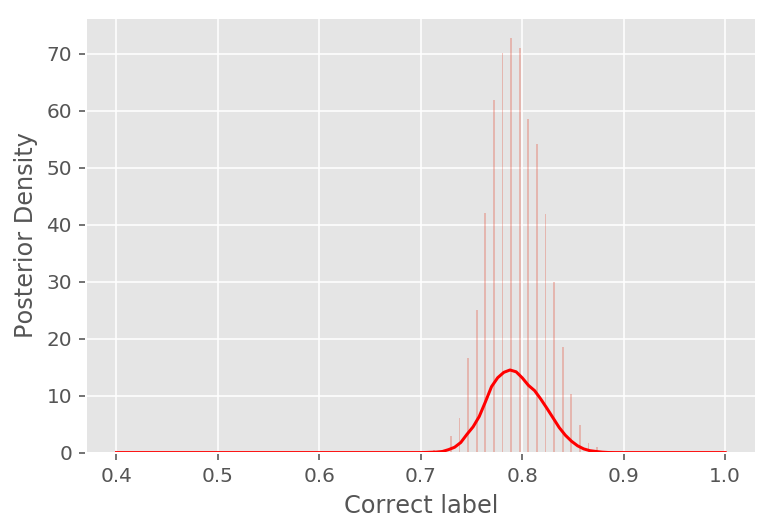

In [13]:
from scipy.stats.kde import gaussian_kde # for plotting: to calculate a continuous 
                                         # approximation of the posterior and prior densities. 
burnin=0
# pymc2
# ztrace =  mcmc.trace("zi")[burnin:]
# pymc3
ztrace = trace7['zi'][burnin:]

print(np.mean(ztrace[-1:]==(t1[0,:]==1)))
pc=np.mean(ztrace==(t1[0,:]==1),axis=1)

my_pdf = gaussian_kde(pc)
x=np.linspace(.4, 1, 100)
plt.plot(x,my_pdf(x),'r') # distribution function
plt.hist(pc, bins=100, normed=1, alpha=.3)
plt.xlabel('Correct label')
plt.ylabel('Posterior Density');

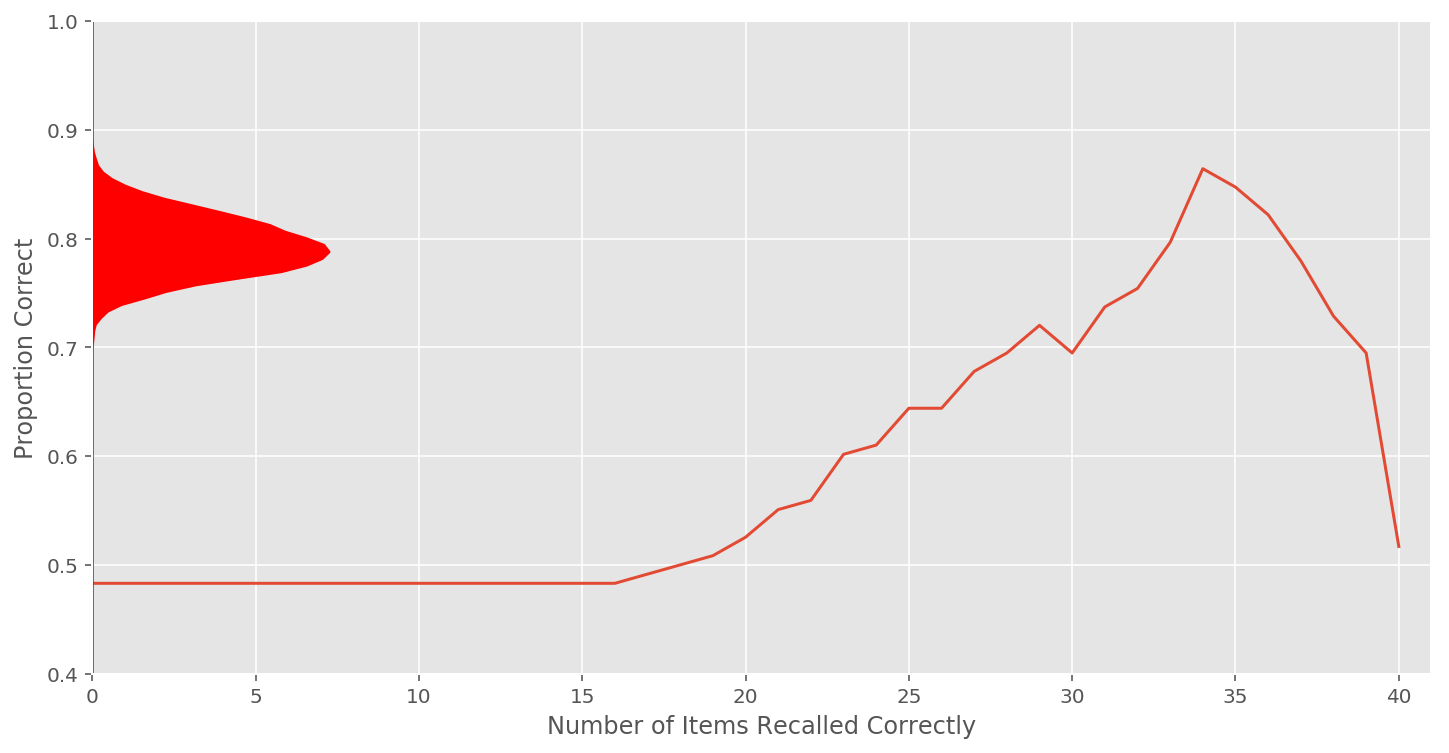

In [14]:
fig = plt.figure(figsize=(12, 6))
my_pdf = gaussian_kde(pc)
x=np.linspace(0.4, 1, 100)
tmp = np.zeros(n+1)
for i in range(n+1):
    tmp[i] = np.mean((k>i)==(t1[0,:]==1))
plt.plot(tmp)
pdfpc=my_pdf(x)/2
plt.plot(pdfpc,x,'r') 
plt.fill_between(pdfpc,x,0,color='r')
plt.axis([0,41,.4,1])
plt.xlabel('Number of Items Recalled Correctly')
plt.ylabel('Proportion Correct');

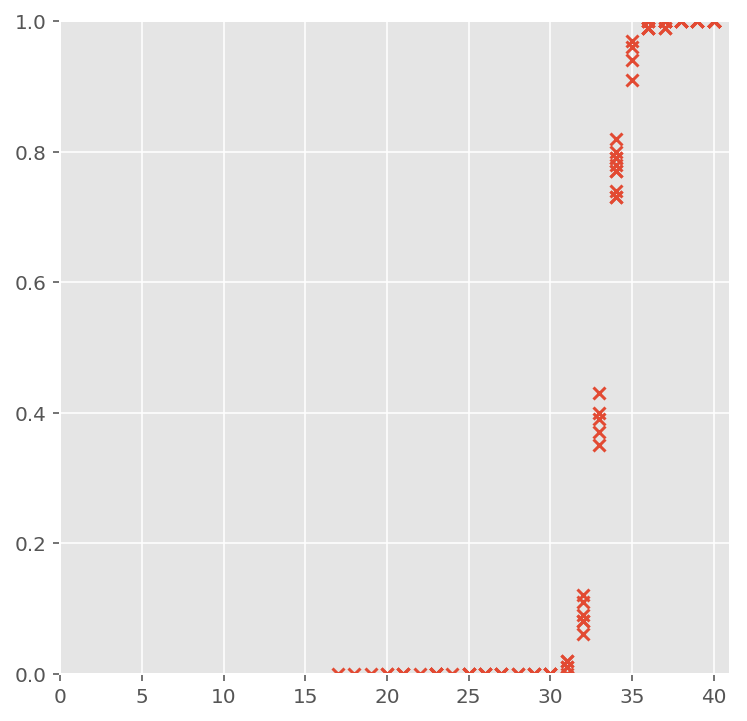

In [15]:
pc2=np.mean(ztrace[0:100],axis=0)
# pc2.shape
plt.figure(figsize=(6, 6))
plt.scatter(k, pc2,marker='x')
plt.axis([0,41,0,1]);